# RQ_2: Impact of Communication Styles and Content Themes on Virality

This notebook addresses Research Question 2 (RQ2) of the thesis, examining how communication styles and content themes on TikTok influence video virality during the Nepal Local Election 2022. We focus on political content, analyzing the interaction between communication styles (`Style_1_label`) and content themes (`content_label`), and their impact on virality using statistical modeling and visualizations. The dataset used is `Merged_Multimodal_Final_3k_Classified.csv`.

---

### 1. Import Libraries and Load Data

We start by importing necessary libraries and loading the dataset.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import boxcox, skew, kurtosis
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [3]:
# Load the dataset

df = pd.read_csv("data/NPL_TikTok_3k_with_Embeddings.csv", sep=";")

### 2. Data Overview and Preprocessing

We explore the dataset, create short aliases for content themes, and filter for political content relevant to the election.



#### 2.1 Dataset Overview


In [5]:
# Display unique values for key columns
print("Unique Communication Styles (Style_1_label):")
print(df['Style_1_label'].unique())
print("\nUnique Content Themes (content_label):")
print(df['content_label'].unique())

Unique Communication Styles (Style_1_label):
['Comedic' 'Music/Entertainment' 'Critique/Frustration' 'Civic Awareness'
 'Event Coverage' 'Charisma/Leadership' 'Communal' 'Personal Vlog/Family'
 'Interactive' 'Others' 'Not Codeable' '0']

Unique Content Themes (content_label):
['Funny' 'General Election Song' 'Speech/Explanatory'
 'UML (सुर्य/एमाले) Support/Song'
 'Independent (स्वतन्त्र) (Balen, Harka, Gopal/Gopi Hamal) Support/Song'
 'Maoist (हँसिया/हतौडा/Sickle) Support/Song' 'Others/Unclassified'
 'Instrumental/Background Music' 'Congress (काँग्रेस/रुख) Support/Song'
 'TikTok Trends' 'Bhojpuri/Maithili Song' 'South Indian Action/Drama'
 'Sigma/Thug life Sound' 'Bollywood/Hindi' 'Sad Song' 'Rap Song'
 'Nepali Folk/Traditional Song' 'Nepali Pop/Modern Song'
 'Movie Dialogue - Nepali' 'Nepali Patriotic Song']


#### 2.2 Create Short Aliases for Content Themes



In [6]:
# Define mapping for content themes to short aliases
label_mapping = {
    "UML (सुर्य/एमाले) Support/Song": "CPN(UML)",
    "Congress (काँग्रेस/रुख) Support/Song": "NepaliCongress",
    "Maoist (हँसिया/हतौडा/Sickle) Support/Song": "CPN(Maoist)",
    "Independent (स्वतन्त्र) (Balen, Harka, Gopal/Gopi Hamal) Support/Song": "Independent",
    "General Election Song": "Election",
    "Speech/Explanatory": "Speech",
    "Bollywood/Hindi/Urdu Song": "Bollywood",
    "Nepali Pop/Modern Song": "NepaliPop/Modern",
    "Nepali Folk/Traditional Song": "Folk",
    "Nepali Sad Song": "SadSong",
    "Nepali Patriotic Song": "Patriotic",
    "Rap Song": "Rap/Metal",
    "Bhojpuri/Maithili Song": "Bhojpuri",
    "Funny": "Funny",
    "TikTok Trends": "Trends",
    "Sigma/Thug life Sound": "Sigma",
    "Movie Dialogue - Nepali": "NepaliDialogue",
    "South/Indian Action/Drama/Dialogue": "SouthDrama",
    "Instrumental/Background Music": "Instrumental",
    "Urdu": "Urdu",
    "Others/Unclassified": "Other"
}

# Apply mapping to create a new column
df['content_short'] = df['content_label'].map(label_mapping)

#### 2.3 Filter for Political Content



In [7]:
# Define political content labels
political_labels = [
    "Independent (स्वतन्त्र) (Balen, Harka, Gopal/Gopi Hamal) Support/Song",
    "UML (सुर्य/एमाले) Support/Song",
    "Congress (काँग्रेस/रुख) Support/Song",
    "Maoist (हँसिया/हतौडा/Sickle) Support/Song",
    "General Election Song"
]

# Filter dataset for political content
df_politics = df[df['content_label'].isin(political_labels)].copy()

# Map to short party names
label_mapping_politics = {
    "UML (सुर्य/एमाले) Support/Song": "UML",
    "Congress (काँग्रेस/रुख) Support/Song": "Congress",
    "Maoist (हँसिया/हतौडा/Sickle) Support/Song": "Maoist",
    "Independent (स्वतन्त्र) (Balen, Harka, Gopal/Gopi Hamal) Support/Song": "Independent",
    "General Election Song": "Election"
}

df_politics['content_short'] = df_politics['content_label'].map(label_mapping_politics)

# Check distribution
print("\nDistribution of Political Content Themes:")
print(df_politics['content_short'].value_counts())



Distribution of Political Content Themes:
content_short
Election       687
UML            271
Congress       256
Independent    232
Maoist          84
Name: count, dtype: int64


#### 2.4 Clean Communication Styles



In [8]:
# Combine low-frequency styles into 'Miscellaneous'
low_freq_styles = ['Others', 'Not Codeable', 'Interactive']
df_politics.loc[df_politics['Style_1_label'].isin(low_freq_styles), 'Style_1_label'] = 'Miscellaneous'

# Display updated distribution
print("\nDistribution of Communication Styles:")
print(df_politics['Style_1_label'].value_counts())


Distribution of Communication Styles:
Style_1_label
Music/Entertainment     492
Event Coverage          274
Civic Awareness         172
Personal Vlog/Family    134
Comedic                 108
Charisma/Leadership     103
Communal                 91
Miscellaneous            83
Critique/Frustration     69
0                         4
Name: count, dtype: int64


### 3. Exploratory Data Analysis (EDA)
We explore the distribution of virality scores, video durations, hashtag counts, and temporal features.



#### 3.1 Virality Score Distribution



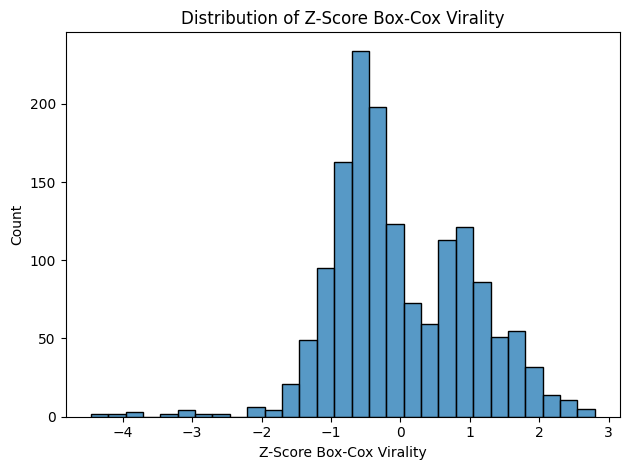

Skewness of virality_score: 0.481303509226457
Kurtosis of virality_score: 0.12749291467262047
Skewness of z_bc_virality: 0.01760246419101652
Kurtosis of z_bc_virality: 0.7408517143256064


In [10]:
# Apply Box-Cox transformation and standardize virality score
df_politics['bc_virality'], _ = boxcox(df_politics['virality_score'] + 1)
df_politics['z_bc_virality'] = StandardScaler().fit_transform(df_politics[['bc_virality']])

# Plot transformed distribution
sns.histplot(df_politics['z_bc_virality'])
plt.title('Distribution of Z-Score Box-Cox Virality')
plt.xlabel('Z-Score Box-Cox Virality')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Compute skewness and kurtosis
print("Skewness of virality_score:", skew(df_politics['virality_score']))
print("Kurtosis of virality_score:", kurtosis(df_politics['virality_score']))
print("Skewness of z_bc_virality:", skew(df_politics['z_bc_virality']))
print("Kurtosis of z_bc_virality:", kurtosis(df_politics['z_bc_virality']))

#### 3.2 Video Duration and Hashtag Count




Video Duration Stats:
count    1530.000000
mean       25.771895
std        31.768635
min         3.000000
25%        13.000000
50%        15.000000
75%        24.000000
max       300.000000
Name: file_duration, dtype: float64


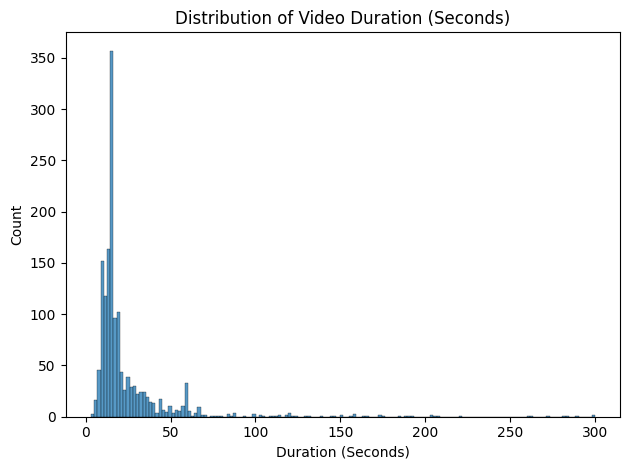


Hashtag Count Stats:
count    1530.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: hashtag_count, dtype: float64


In [11]:
# Video duration analysis
df_politics['scale_file_duration'] = StandardScaler().fit_transform(df_politics[['file_duration']])
print("\nVideo Duration Stats:")
print(df_politics['file_duration'].describe())

sns.histplot(df_politics['file_duration'])
plt.title('Distribution of Video Duration (Seconds)')
plt.xlabel('Duration (Seconds)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Hashtag count analysis
df_politics['hashtag_count'] = df_politics['hashtags_metadata'].apply(
    lambda x: len(str(x).split()) if pd.notna(x) else 0
)
df_politics['scale_hashtag_count'] = StandardScaler().fit_transform(df_politics[['hashtag_count']])
print("\nHashtag Count Stats:")
print(df_politics['hashtag_count'].describe())

#### 3.3 Temporal Features



In [13]:
# Compute days before election
# Ensure both datetime objects are timezone-naive
df_politics['video_time_created'] = pd.to_datetime(df_politics['video_time_created']).dt.tz_localize(None)
df_politics['days_before_election'] = (
    pd.to_datetime('2022-05-13') - df_politics['video_time_created']
).dt.days
print("\nDays Before Election Stats:")
print(df_politics['days_before_election'].describe())


Days Before Election Stats:
count    1530.000000
mean        8.832680
std        10.201859
min        -1.000000
25%         2.000000
50%         7.000000
75%        12.000000
max        58.000000
Name: days_before_election, dtype: float64


### 4. Analyze Communication Styles and Content Themes
We examine the relationship between communication styles and content themes using heatmaps and statistical modeling.



#### 4.1 Heatmap of Style vs. Content Theme



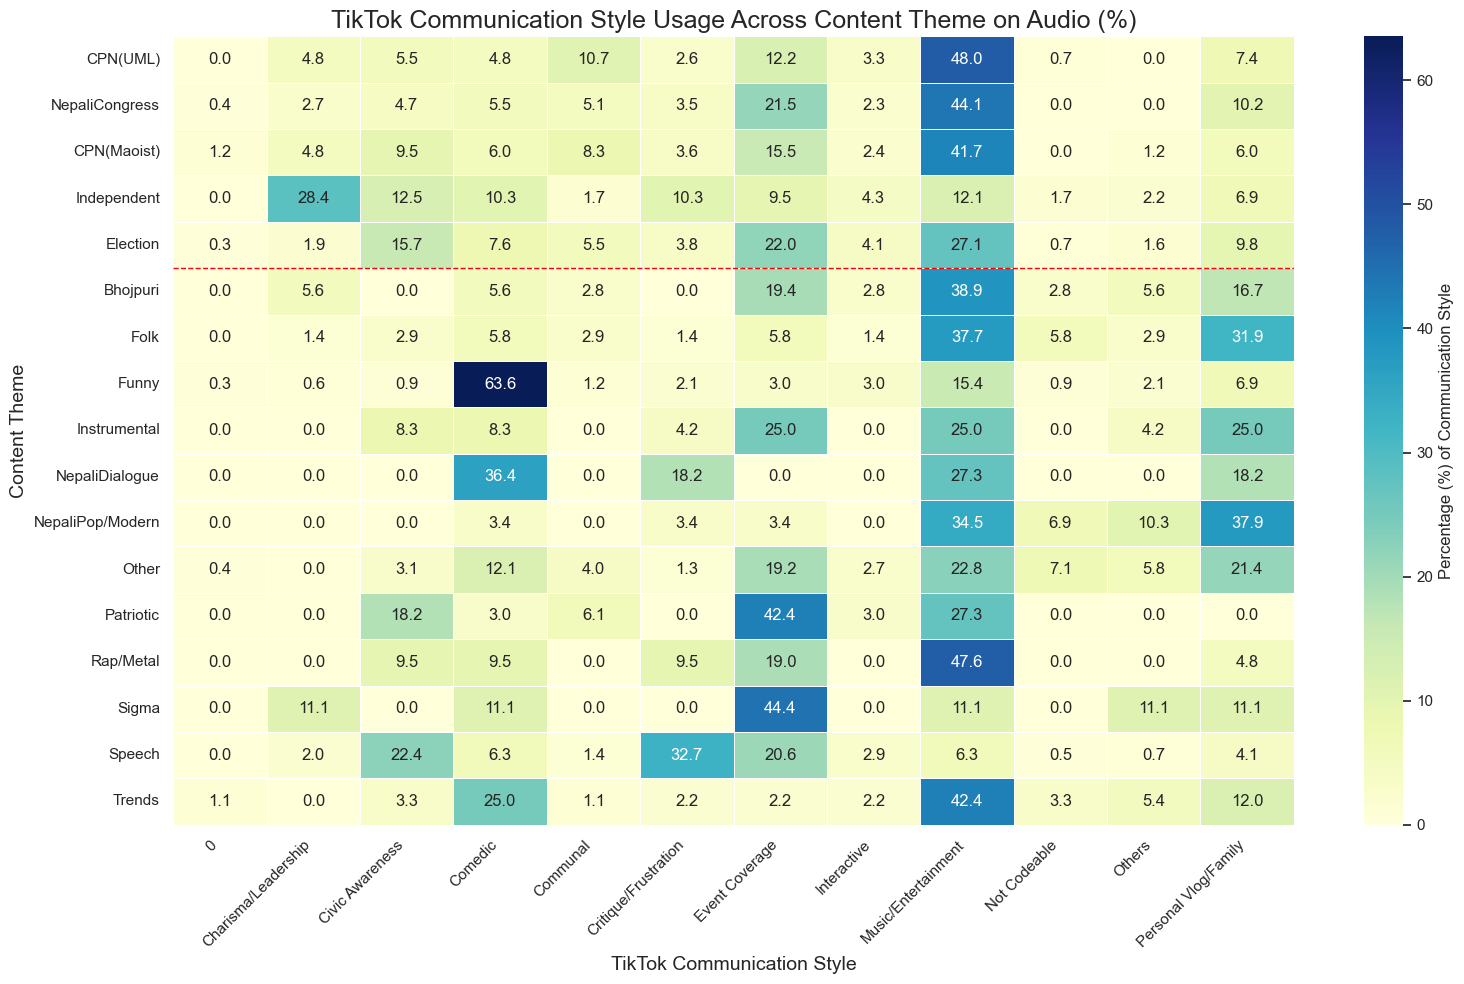

In [14]:
# Create heatmap of communication style usage across content themes
combo_counts = df.groupby(['content_short', 'Style_1_label']).size().reset_index(name='count')
heatmap_df = combo_counts.pivot(index='content_short', columns='Style_1_label', values='count').fillna(0)
heatmap_normalized = heatmap_df.div(heatmap_df.sum(axis=1), axis=0)

# Sort index to prioritize political labels
political_labels = ['CPN(UML)', 'NepaliCongress', 'CPN(Maoist)', 'Independent', 'Election']
heatmap_normalized = heatmap_normalized.loc[
    political_labels + [label for label in heatmap_normalized.index if label not in political_labels]
]

# Plot heatmap
plt.figure(figsize=(16, 10))
sns.set(style="whitegrid")
ax = sns.heatmap(
    heatmap_normalized * 100,
    cmap="YlGnBu",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
    cbar_kws={'label': 'Percentage (%) of Communication Style'}
)

# Draw horizontal line after political labels
plt.axhline(y=len(political_labels), color='red', linestyle='--', linewidth=1)
plt.title("TikTok Communication Style Usage Across Content Theme on Audio (%)", fontsize=18)
plt.xlabel("TikTok Communication Style", fontsize=14)
plt.ylabel("Content Theme", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### 4.2 Clustermap for Patterns



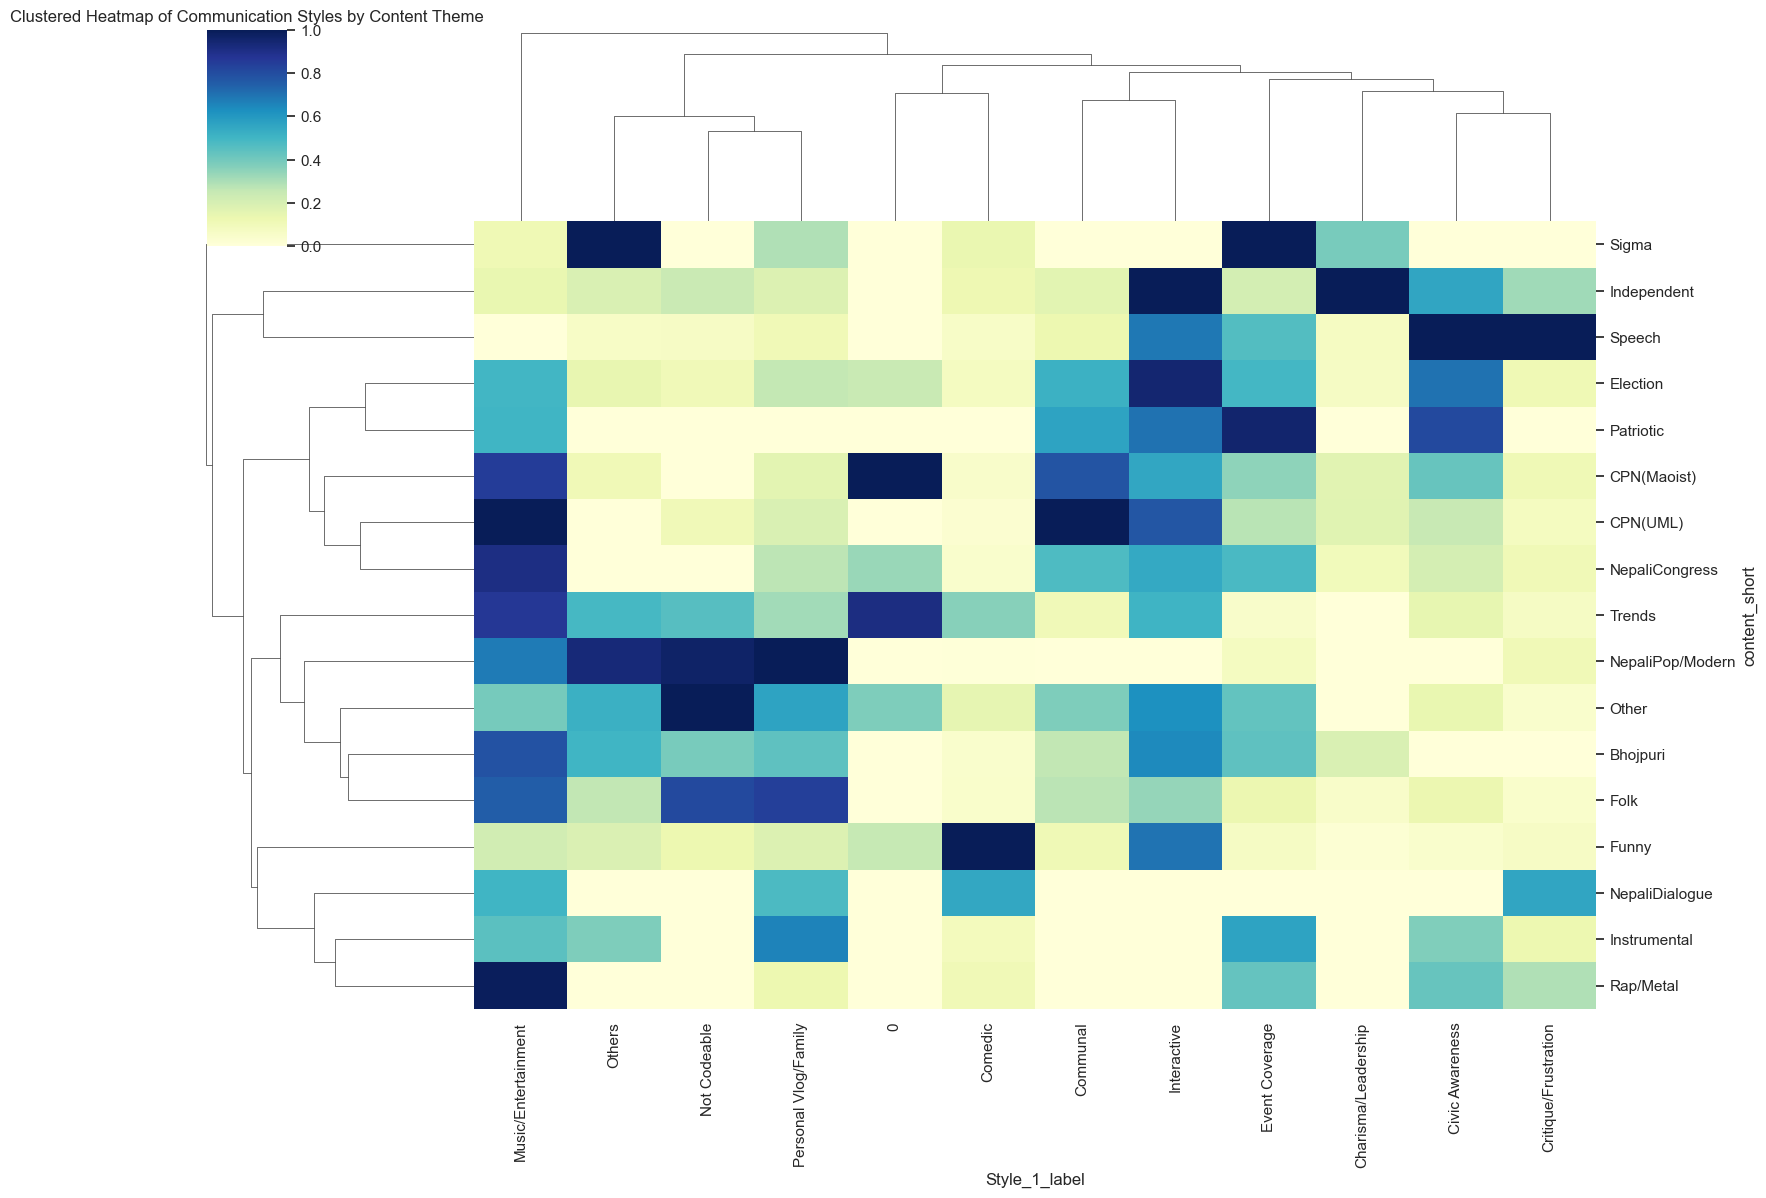

In [15]:
# Create a clustermap to identify patterns
sns.clustermap(
    heatmap_normalized,
    cmap="YlGnBu",
    figsize=(16, 12),
    standard_scale=1,  # Normalize across rows
    col_cluster=True,
    row_cluster=True
)
plt.title("Clustered Heatmap of Communication Styles by Content Theme")
plt.show()

#### 4.3 Crosstab Heatmap for Political Content



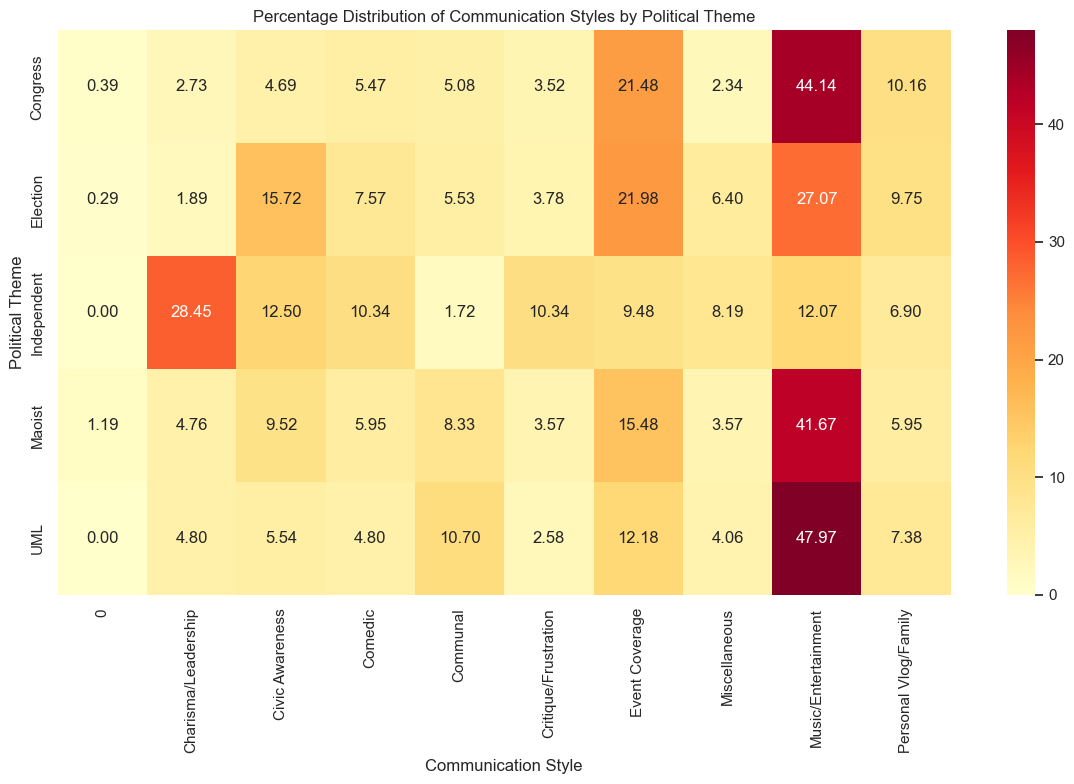

In [16]:
# Crosstab heatmap for political content
crosstab = pd.crosstab(df_politics['content_short'], df_politics['Style_1_label'], normalize='index') * 100
plt.figure(figsize=(12, 8))
sns.heatmap(crosstab, cmap="YlOrRd", annot=True, fmt=".2f")
plt.title("Percentage Distribution of Communication Styles by Political Theme")
plt.xlabel("Communication Style")
plt.ylabel("Political Theme")
plt.tight_layout()
plt.show()

#### 4.4 Summary Statistics by Content Theme



In [17]:
# Compute mean statistics by content theme
print("\nMean Statistics by Content Theme:")
print(df_politics.groupby('content_short')[
    ['z_bc_virality', 'followers', 'video_commentcount', 'days_before_election']
].mean())


Mean Statistics by Content Theme:
               z_bc_virality  followers  video_commentcount  \
content_short                                                 
Congress           -0.074036  -0.143417           22.742188   
Election           -0.125630  -0.103504           17.848617   
Independent         0.494888   0.347832           89.943966   
Maoist              0.141119  -0.076416           66.202381   
UML                -0.078993  -0.118461           29.708487   

               days_before_election  
content_short                        
Congress                   9.500000  
Election                   7.066958  
Independent                9.426724  
Maoist                    13.845238  
UML                       10.616236  


### 5. Statistical Modeling: OLS Regression
We use OLS regression to model the impact of communication styles and content themes on virality, including interaction effects and control variables.



In [18]:
# Prepare features for regression
df_politics['log_followers'] = np.log1p(df_politics['followers'])
df_politics['Style_1_label'] = df_politics['Style_1_label'].astype('category')
df_politics['content_short'] = df_politics['content_short'].astype('category')
df_politics['author_verified'] = df_politics['author_verified'].astype('category')

# OLS model with interaction and controls
model = smf.ols(
    formula='z_bc_virality ~ C(Style_1_label) * C(content_short) + log_followers + days_before_election + C(author_verified)',
    data=df_politics
).fit()

# Display results
print(model.summary())

# Save model summary as LaTeX
with open('model_summary.tex', 'w') as f:
    f.write(model.summary().as_latex())

                            OLS Regression Results                            
Dep. Variable:          z_bc_virality   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     8.029
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           1.18e-48
Time:                        20:16:15   Log-Likelihood:                -1987.3
No. Observations:                1530   AIC:                             4077.
Df Residuals:                    1479   BIC:                             4349.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                                                                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

#### 5.1 Check for Multicollinearity



In [19]:
# Compute Variance Inflation Factors (VIF) to check for multicollinearity
X = pd.get_dummies(df_politics[['Style_1_label', 'content_short']], drop_first=True)
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVariance Inflation Factors:")
print(vif_data)



Variance Inflation Factors:
                              Variable       VIF
0    Style_1_label_Charisma/Leadership  0.015540
1        Style_1_label_Civic Awareness  0.010054
2                Style_1_label_Comedic  0.012969
3               Style_1_label_Communal  0.014585
4   Style_1_label_Critique/Frustration  0.018450
5         Style_1_label_Event Coverage  0.006745
6          Style_1_label_Miscellaneous  0.016260
7    Style_1_label_Music/Entertainment  0.004911
8   Style_1_label_Personal Vlog/Family  0.010584
9               content_short_Election  0.005472
10           content_short_Independent  0.009513
11                content_short_Maoist  0.015748
12                   content_short_UML  0.007653


### 6. Visualize Interaction Effects
We create a heatmap to visualize the mean virality scores across communication styles and political themes.



/var/folders/vz/qgddhj1d00b_xrxhd73v0fdc0000gn/T/ipykernel_38863/2627661312.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df_politics.pivot_table(


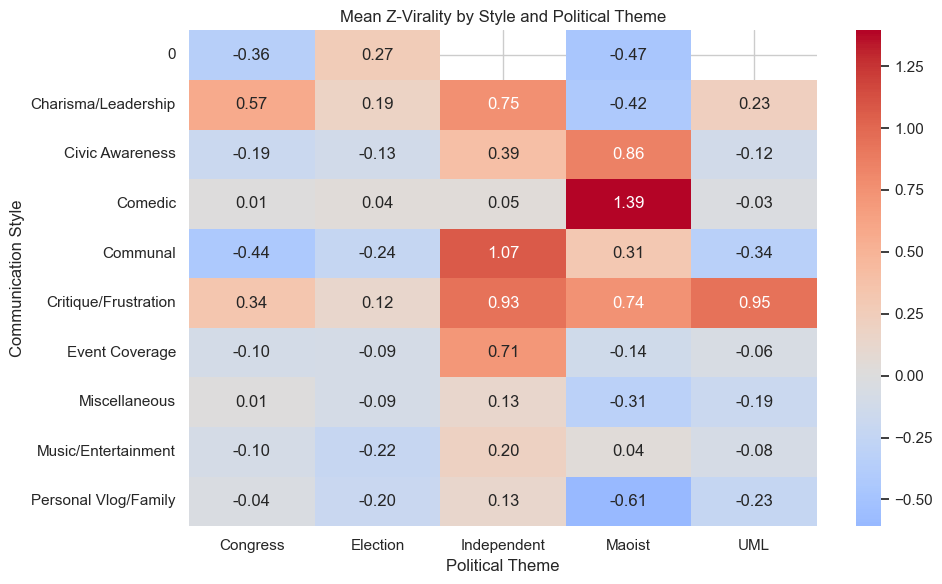

In [20]:
# Pivot table for mean z_bc_virality
pivot = df_politics.pivot_table(
    index='Style_1_label', columns='content_short',
    values='z_bc_virality', aggfunc='mean'
)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Mean Z-Virality by Style and Political Theme")
plt.ylabel("Communication Style")
plt.xlabel("Political Theme")
plt.tight_layout()
plt.show()